In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import spatial

In [2]:
# Drawing/vizualization primitives

def draw_points_on_image(img, roots_coords):
    img_with_points = img.copy()
    for p in roots_coords:
        cv2.circle(img_with_points, (p[0], p[1]), 3, (255, 255, 255), -1)
        
    return img_with_points

def imshow_plaint(img, name='Image'):
    plt.imshow(img, cmap='gray')
    plt.title(name), plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
# Color measurements utils

def compute_mean_color(img, points, w=1):
    mean_list = []
    for p in points:         
        mean_list.append(img[p[1] - w : p[1] + w + 1, p[0] - w : p[0] + w + 1])
    
    measure_number = (2 * w + 1) * (2 * w + 1) * len(points)
    mean_array = np.asarray(mean_list)
     
    return np.mean(np.resize(mean_array, (measure_number, 3)), 0)

In [4]:
# Color transformation utils

# Description: transform one three dimensional pixel
# RGB -> Labet:
#    L = r + g + b / 3    
#    alpha = r - b 
#    beta = g - r  - b / 2
def transform_pixel_color(p, flag):
    if(flag == 'BGR2LABET'):
        m = np.array([0.0,0.0,0.0])
        m[0] = np.sum(p)/3
        m[1] = p[2] - p[0]
        m[2] = p[1] - [0] - p[2]
        return m

# Description: (will be iproved with othre color systems further) transform three-dimensional image
# RGB -> Labet:
#    L = r + g + b / 3    
#    alpha = r - b 
#    beta = g - r  - b / 2
def transform_image_color(img, flag):
    if(flag == 'BGR2LABET'):
        img_in_labet = np.zeros_like(img)
        img_in_labet[...,0] = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3
        img_in_labet[...,1] = img[:,:,2] - img[:,:,0]
        img_in_labet[...,0] = img[:,:,1] - img[:,:,0] - img[:,:,2]
        return img_in_labet

In [70]:
# Hardcoded path and points

img = cv2.imread("/home/ruff/Work/TrackClimb/root_detector/ds/roots/imgs+markup/anton_24_3.jpg")
img_f = img.astype('float') # important for further transformations and computation

roots_coords = [(243,96), 
                (201,136), 
                (239,205), 
                (159,242), 
                (262,317),
                (175,354),
                (278,401),
                (247,485)]

roots_coords_yx = [ (96, 243), 
                    (136, 201), 
                    (205, 239), 
                    (242, 159), 
                    (317, 262),
                    (354, 175),
                    (401, 278),
                    (485, 247)]

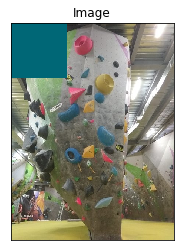

In [17]:
# Measure and vizualize color of pitches

mean_color = compute_mean_color(img, roots_coords, 0)

img_temp = img.copy()
img_temp[0:150, 0:150] = 0
for i in range(0,2):
    img_temp[0:150, 0:150, i]  = int(mean_color[i])

img_to_show = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
imshow_plaint(img_to_show)

In [116]:
# Pitch pixel detection

mean_color_labet = transform_pixel_color(mean_color, 'BGR2LABET')
img_labet = transform_image_color(img_f, 'BGR2LABET')

img_coloration = img_labet[:, :, 1 : 3]
mean_colorartion = mean_color_labet[1 : 3]

n, m, _ = img_coloration.shape
img_coloration_vec = np.reshape(img_coloration, ((n * m), 2))
        
dp = img_coloration_vec @ mean_colorartion
weights = np.reshape(dp, (n, m))

mask = np.copy(weights)
mask[mask < 0] = 0

maxval = np.max(mask)
mask *= 255 / maxval;
mask2 = mask.astype('uint8')
ret, tr = cv2.threshold(mask2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel_wind = 5
kernel = np.ones((kernel_wind, kernel_wind),np.uint8)
tr2 = cv2.dilate(tr,kernel,iterations = 1)

connectivity = 8
num_labels, labels, _, _ = cv2.connectedComponentsWithStats(tr2, connectivity, cv2.CV_32S)

true_labels = [];
for point in roots_coords_yx:
    true_labels.append(labels[point])

labels_false = (list(set(range(0, num_labels)) - set(true_labels)))

for l in labels_false:
    labels[labels == l] = 0

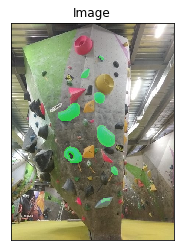

True

In [117]:
# Pitch pixel area highliting

img_out = np.copy(img)

for i in range(0, n):
    for j in range(0, m):
        if labels[i,j] != 0:
            img_out[i, j, 1] = 200

img_to_show = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
imshow_plaint(img_to_show)

cv2.imwrite('/home/ruff/Desktop/img_out.png', img_out)